In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from cmcrameri import cm

In [56]:
#directory = "/import/freenas-m-04-students/fkutschera/simulations/HFFZ_fullycp_o5_180s/"
directory = "/import/freenas-m-04-students/fkutschera/simulations/HFFZ_fullycp_o5_180s_II/"
#file = "HFFZ_fullycp-receiver-00039-00031.dat"
#file = "HFFZ_fullycp-receiver-00116-00014.dat"
#file = "HFFZ_fullycp-receiver-00164-00011.dat"
file = "HFFZ_full-receiver-00483-00008.dat"

In [57]:
column_names = ["Time","xx","yy","zz","xy","yz","xz","u","v","w"]

In [58]:
df = pd.read_csv(directory+file, skiprows=5, sep='\s+', names=column_names)
df.drop(columns=["xx","yy","zz","xy","yz","xz"], inplace=True)
df.head()

,Time,u,v,w
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,0.1,0.000000e+00,0.000000e+00,0.000000e+00
2,0.2,0.000000e+00,0.000000e+00,0.000000e+00
3,0.3,-2.359903e-133,6.971712e-134,1.713360e-133
4,0.4,-1.473553e-95,1.093060e-95,1.121700e-95


In [59]:
coords = pd.read_csv(directory+file, nrows=3, skiprows=2, header=None, sep="\s+") #names=["x1", "x2", "x3"]
x1 = coords[2][0]
x2 = coords[2][1]
x3 = coords[2][2]

In [60]:
df["x1"]=x1
df["x2"]=x2
df["x3"]=x3
df.head()

,Time,u,v,w,x1,x2,x3
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,623500.4,7345316.0,-0.1
1,0.1,0.000000e+00,0.000000e+00,0.000000e+00,623500.4,7345316.0,-0.1
2,0.2,0.000000e+00,0.000000e+00,0.000000e+00,623500.4,7345316.0,-0.1
3,0.3,-2.359903e-133,6.971712e-134,1.713360e-133,623500.4,7345316.0,-0.1
4,0.4,-1.473553e-95,1.093060e-95,1.121700e-95,623500.4,7345316.0,-0.1


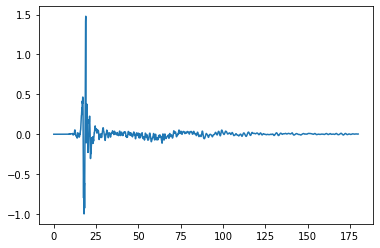

In [61]:
plt.plot(df.Time,df.w)

In [63]:
max(df.Time)

179.8999999999941

In [85]:
# need to adjust time due to floating point errors/ rounding
time_length = 1800
df["Time"] = np.linspace(0, 179.9, time_length)
df.loc[df['Time'] == 40.0]

,Time,u,v,w,x1,x2,x3
400,40.0,-0.025406,-0.036261,0.025252,623500.4,7345316.0,-0.1


In [65]:
max(df.Time)

179.9

# Stack

In [66]:
files = glob.glob(os.path.join(directory, "HFFZ_full-receiver*.dat"))

In [67]:
for f in files:
    frame = pd.read_csv(f, skiprows=5, sep='\s+', names=column_names)
    frame.drop(columns=["xx","yy","zz","xy","yz","xz"], inplace=True)
    coords = pd.read_csv(f, nrows=3, skiprows=2, header=None, sep="\s+")
    x1 = coords[2][0]
    x2 = coords[2][1]
    x3 = coords[2][2]
    frame["x1"]=x1
    frame["x2"]=x2
    frame["x3"]=x3
    if (files[0]==f):
        stack = frame.loc[df['Time'] == 20.0]
    else:
        stack = pd.concat([stack, frame.loc[df['Time'] == 20.0]])

In [68]:
stack.sort_values(by="x1", inplace=True)

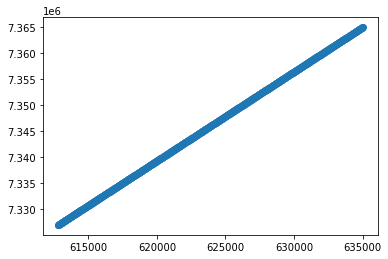

In [69]:
plt.plot(stack.x1,stack.x2,'o')

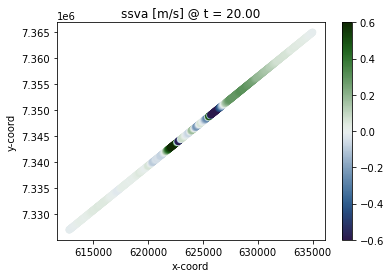

In [123]:
sc = plt.scatter(stack.x1,stack.x2, c=stack.w, vmin=-0.6, vmax=0.6, s=40, cmap=cm.cork)
plt.colorbar(sc)
plt.xlabel("x-coord")
plt.ylabel("y-coord")
plt.title("ssva [m/s] @ t = {:.2f}".format(stack["Time"].iloc[0]))
plt.show()

In [71]:
# calculate distance - Attention, might be wrong!!!
#stack['Distance'] = 0
#for i in range(len(stack)-1):
#    stack['Distance'].iloc[i+1] = stack['Distance'].iloc[i] + np.sqrt((stack['x1'].iloc[i+1] - stack['x1'].iloc[i])**2 + (stack['x2'].iloc[i+1] - stack['x2'].iloc[i])**2)
#stack

In [72]:
# Attention: distance might be wrong due to curvature of the Earth
#plt.plot(stack.Distance, stack.w)

# Check distance

In [73]:
def conversion_xy2length(x_start,y_start,x_end,y_end):
    from pyproj import Transformer
    transformer = Transformer.from_crs("utm27", "epsg:4326", always_xy=True)
    lon_start, lat_start = transformer.transform(x_start, y_start)
    lon_end, lat_end = transformer.transform(x_end, y_end)
    
    import geopy.distance 
    coords_1 = (lon_start, lat_start)
    coords_2 = (lon_end, lat_end)
    length = geopy.distance.geodesic(coords_1, coords_2).km
    return length 

In [74]:
x_start = stack['x1'].iloc[0]
y_start = stack['x2'].iloc[0]
x_end = stack["x1"].iloc[len(stack)-1]
y_end = stack["x2"].iloc[len(stack)-1]

length = conversion_xy2length(x_start,y_start,x_end,y_end)
length 

68.32498502761707

In [75]:
distance = np.linspace(0,length,len(stack))
len(distance)

1001

Text(0.5, 1.0, 'trace @ t = 20.00')

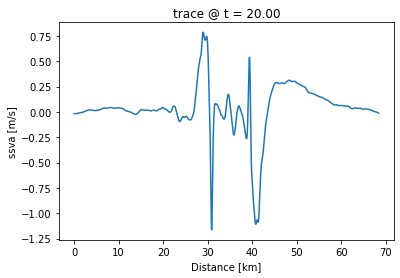

In [124]:
plt.plot(distance, stack.w)
plt.xlabel("Distance [km]")
plt.ylabel("ssva [m/s]")
plt.title("trace @ t = {:.2f}".format(stack["Time"].iloc[0]))

# Make 2D surface plot

In [77]:
stack

,Time,u,v,w,x1,x2,x3
200,20.0,0.000475,-0.000091,-0.017425,612800.0,7327000.0,-0.1
200,20.0,0.001114,0.002929,-0.017835,612822.2,7327038.0,-0.1
200,20.0,-0.000354,0.000189,-0.018036,612844.4,7327076.0,-0.1
200,20.0,-0.001399,0.000155,-0.017835,612866.6,7327114.0,-0.1
200,20.0,-0.002116,0.000039,-0.017665,612888.8,7327152.0,-0.1
...,...,...,...,...,...,...,...
200,20.0,-0.000247,0.000027,-0.004812,634911.2,7364848.0,-0.1
200,20.0,-0.000246,0.000110,-0.005778,634933.4,7364886.0,-0.1
200,20.0,-0.000243,0.000274,-0.006922,634955.6,7364924.0,-0.1
200,20.0,-0.000255,0.000452,-0.008695,634977.8,7364962.0,-0.1


In [81]:
DISTANCE, TIME = np.meshgrid(distance,stack.Time)

In [89]:
row_nr = len(stack)
col_nr = time_length
rows, cols = (row_nr, col_nr)
arr=[]
for i in range(rows):
    col = []
    for j in range(cols):
        col.append(0)
    arr.append(col)

In [91]:
x = np.linspace(-5, 5, 101)

y = np.linspace(-5, 5, 101)

# full coordinate arrays

xx, yy = np.meshgrid(x, y)

zz = np.sqrt(xx**2 + yy**2)

xx.shape, yy.shape, zz.shape
((101, 101), (101, 101), (101, 101))

# sparse coordinate arrays

xs, ys = np.meshgrid(x, y, sparse=True)

zs = np.sqrt(xs**2 + ys**2)

xs.shape, ys.shape, zs.shape
((1, 101), (101, 1), (101, 101))

((1, 101), (101, 1), (101, 101))

In [96]:
ti = np.linspace(0, 179.9, time_length)
#distance

In [97]:
DI, TI = np.meshgrid(distance, ti)

In [107]:
ssva = (stack.w)
ssva

200   -0.017425
200   -0.017835
200   -0.018036
200   -0.017835
200   -0.017665
         ...   
200   -0.004812
200   -0.005778
200   -0.006922
200   -0.008695
200   -0.012426
Name: w, Length: 1001, dtype: float64

In [106]:
DI.shape, TI.shape, ssva.shape

((1800, 1001), (1800, 1001), (1001,))

In [116]:
SSVA = np.tile(ssva, (time_length, 1))
SSVA.shape

(1800, 1001)

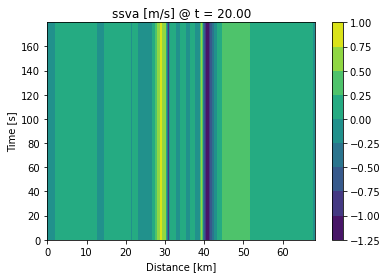

In [127]:
plt.contourf(DI, TI, SSVA)
plt.xlabel("Distance [km]")
plt.ylabel("Time [s]")
plt.title("ssva [m/s] @ t = {:.2f}".format(stack["Time"].iloc[0]))
plt.colorbar()

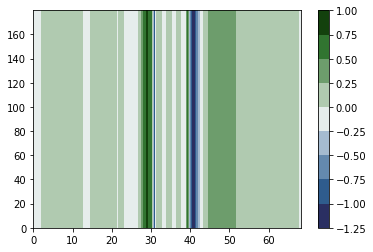

In [129]:
h = plt.contourf(DI, TI, SSVA, cmap=cm.cork)
plt.colorbar(h)